## Load Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
import glob
from scipy import interpolate
from collections import Counter

In [5]:
types_vocab = ["EXP", "HIB", "LP", "PIS", "TOR", "TR", "VT"]

In [20]:
# table = pd.read_excel("data/association_table_corrected_index.xlsx")
table = pd.read_pickle("data/table.pkl")

In [21]:
table.head()

,Index,Event,Duration,Event start,Event stop,File name,File start,File end,Sampling rate,Overlap,Unnamed: 10,Unnamed: 11,Unnamed: 12,npts,energy,path
0,0,LP1,33,2006-05-23 20:39:27.060000+00:00,2006-05-23 20:40:00.060000+00:00,20060523_2033.UB1.SL.Z.sac,2006-05-23 20:33:05.895000+00:00,2006-05-23 20:43:05.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.24403,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
1,1,LP1,45,2006-05-23 20:39:59.960000+00:00,2006-05-23 20:40:44.960000+00:00,20060523_2033.UB1.SL.Z.sac,2006-05-23 20:33:05.895000+00:00,2006-05-23 20:43:05.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.11833,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
2,2,TR2,128,2006-05-23 22:37:52.910000+00:00,2006-05-23 22:40:00.910000+00:00,20060523_2235.UB1.SL.Z.sac,2006-05-23 22:35:19.895000+00:00,2006-05-23 23:05:19.875000+00:00,50.0,False,NaN,NaN,NaN,90000.0,0.79052,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
3,3,LP1,32,2006-05-23 22:44:09.410000+00:00,2006-05-23 22:44:41.410000+00:00,20060523_2235.UB1.SL.Z.sac,2006-05-23 22:35:19.895000+00:00,2006-05-23 23:05:19.875000+00:00,50.0,False,NaN,NaN,NaN,90000.0,1.15570,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
4,4,TR2,78,2006-05-23 22:46:58.440000+00:00,2006-05-23 22:48:16.440000+00:00,20060523_2245.UB1.SL.Z.sac,2006-05-23 22:45:19.895000+00:00,2006-05-23 22:55:19.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.23330,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...


In [19]:
# table.to_pickle("data/table.pkl")

## Make list of spectrograms

In [22]:
TRAIN_SIZE = 50
TEST_SIZE = 20

In [23]:
t_itp = np.linspace(0, 120, 25)
f_itp = np.linspace(0, 10 ,25)

In [24]:
dict_interps = dict()
counter = Counter()
list_interps = []
list_types = []

In [25]:
# shuffle the dataframe
table = table.sample(frac=1)

In [26]:
for index, row in table.iterrows():
    event = row["Event"]
    event_type = event if event in types_vocab else event[:-1]
    if counter[event_type] >= TRAIN_SIZE + TEST_SIZE:
        continue
    name = event_type + "_" + str(row["Index"])
    filename = name + ".npy"
    try:
        ts = np.load(f"data/Extracted/{event_type}/{filename}")
        f,t,S = signal.spectrogram(ts,row["Sampling rate"])
        func = interpolate.RectBivariateSpline(f,t,S)
    except:
        continue
    S_int = func(f_itp, t_itp)
    # dict_interps[name] = S_int
    list_interps.append(S_int)
    list_types.append(event_type)
    counter[event_type] += 1

In [27]:
len(list_interps)

490

In [28]:
Counter(list_types)

Counter({'LP': 70,
         'TR': 70,
         'PIS': 70,
         'VT': 70,
         'HIB': 70,
         'EXP': 70,
         'TOR': 70})

In [ ]:

# np.savez("./dataset_spectro", **dict_interps)

## Datasets

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
list_types = le.fit_transform(list_types)

In [30]:
dataset = tf.data.Dataset.from_tensor_slices((list_interps, list_types))
dataset

2021-11-16 16:37:59.566541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-16 16:38:00.500277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2196 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:b1:00.0, compute capability: 7.5


<TensorSliceDataset shapes: ((25, 25), ()), types: (tf.float64, tf.int64)>

In [38]:
dataset = tf.data.Dataset.from_tensor_slices((list_interps, list_types))
dataset = dataset.shuffle(TEST_SIZE + TRAIN_SIZE)
test_dataset = dataset.take(TEST_SIZE) 
train_dataset = dataset.skip(TEST_SIZE)
test_dataset = test_dataset.batch(1)
train_dataset = train_dataset.batch(1)
# train_dataset = tf.data.Dataset.from_tensor_slices((list_interps[:20], list_types[:20]))
# test_dataset = tf.data.Dataset.from_tensor_slices((list_interps[20:], list_types[20:]))

In [32]:
test_dataset

<BatchDataset shapes: ((None, 25, 25), (None,)), types: (tf.float64, tf.int64)>

/tmp/ipykernel_43466/1221987843.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_itp,f_itp,list_interps[8])


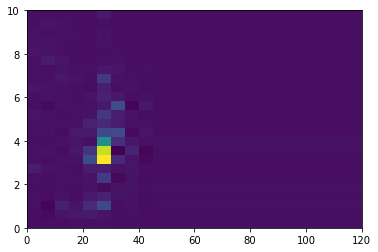

In [33]:
plt.pcolormesh(t_itp,f_itp,list_interps[8])

In [34]:
from tensorflow.keras import datasets, layers, models

In [48]:
dropout_rate = 0.1

model = models.Sequential()
model.add(layers.Reshape((25,25,1), input_shape=(25,25)))
model.add(layers.Conv2D(32, (3,3), activation = "relu", input_shape = (25,25,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = "relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation = "relu"))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(7))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 25, 25, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 23, 23, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 32)          18464     
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)              

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [52]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = "accuracy", patience = 10, restore_best_weights=True)

In [53]:
history = model.fit(train_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50
470/470 [==============================] - 1s 3ms/step - loss: 2.0353 - accuracy: 0.2191
Epoch 2/50
470/470 [==============================] - 1s 3ms/step - loss: 1.8026 - accuracy: 0.2234
Epoch 3/50
470/470 [==============================] - 1s 3ms/step - loss: 1.7647 - accuracy: 0.2191
Epoch 4/50
470/470 [==============================] - 1s 3ms/step - loss: 1.7995 - accuracy: 0.2191
Epoch 5/50
470/470 [==============================] - 1s 3ms/step - loss: 1.7534 - accuracy: 0.2468
Epoch 6/50
470/470 [==============================] - 1s 3ms/step - loss: 1.7630 - accuracy: 0.2340
Epoch 7/50
470/470 [==============================] - 1s 3ms/step - loss: 1.7533 - accuracy: 0.2213
Epoch 8/50
470/470 [==============================] - 1s 3ms/step - loss: 1.8426 - accuracy: 0.2489
Epoch 9/50
470/470 [==============================] - 1s 3ms/step - loss: 1.7182 - accuracy: 0.2404
Epoch 10/50
470/470 [==============================] - 1s 3ms/step - loss: 1.6931 - accuracy: 0.2553

In [54]:
model.evaluate(test_dataset)

20/20 [==============================] - 0s 2ms/step - loss: 2.0640 - accuracy: 0.0000e+00


[2.064044237136841, 0.0]